# Hedging Strategies

Futures and options hedging for coffee commodity risk management.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from src.data_loader import load_csv

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Market Setup

In [2]:
# load actual data
df = load_csv('../data/coffee_futures.csv')

# current market conditions
spot = df['Close'].iloc[-1]
volatility = df['returns'].dropna().std() * np.sqrt(252)

# market parameters
risk_free = 0.05        # 5% risk-free rate
storage_cost = 0.02     # 2% annual storage
convenience = 0.01      # 1% convenience yield

print("MARKET CONDITIONS")
print("=" * 40)
print(f"Spot Price: ${spot:.2f} cents/lb")
print(f"Historical Volatility: {volatility:.1%}")
print(f"Risk-Free Rate: {risk_free:.1%}")
print(f"Storage Cost: {storage_cost:.1%}")
print(f"Convenience Yield: {convenience:.1%}")

MARKET CONDITIONS
Spot Price: $372.65 cents/lb
Historical Volatility: 36.5%
Risk-Free Rate: 5.0%
Storage Cost: 2.0%
Convenience Yield: 1.0%


## 2. Cost of Carry Model

In [3]:
def futures_price(S, r, c, y, T):
    """Cost of carry futures pricing."""
    return S * np.exp((r + c - y) * T)

# futures curve
maturities = [1/12, 3/12, 6/12, 9/12, 1.0]  # months
maturity_labels = ['1M', '3M', '6M', '9M', '12M']

futures_curve = []
for T in maturities:
    F = futures_price(spot, risk_free, storage_cost, convenience, T)
    futures_curve.append(F)

print("FUTURES CURVE")
print("=" * 40)
print(f"{'Maturity':<10} {'Futures Price':>15} {'Basis':>10}")
print("-" * 40)
for label, F in zip(maturity_labels, futures_curve):
    basis = F - spot
    print(f"{label:<10} ${F:>14.2f} ${basis:>9.2f}")

FUTURES CURVE
Maturity     Futures Price      Basis
----------------------------------------
1M         $        374.52 $     1.87
3M         $        378.28 $     5.63
6M         $        384.00 $    11.35
9M         $        389.80 $    17.15
12M        $        395.69 $    23.04


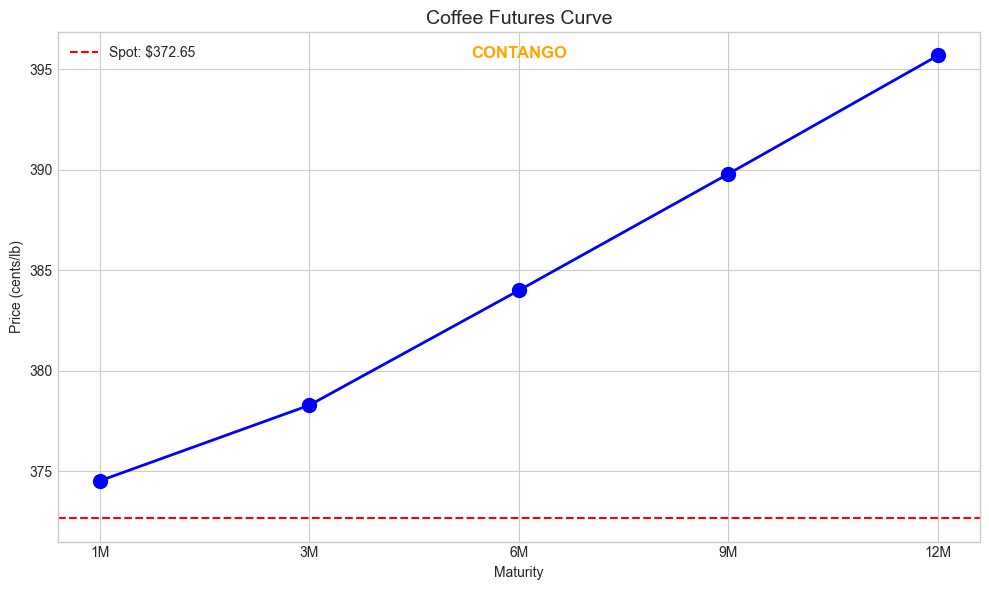

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(maturity_labels, futures_curve, 'bo-', markersize=10, linewidth=2)
ax.axhline(spot, color='red', linestyle='--', label=f'Spot: ${spot:.2f}')

ax.set_xlabel('Maturity')
ax.set_ylabel('Price (cents/lb)')
ax.set_title('Coffee Futures Curve', fontsize=14)
ax.legend()

# annotate contango/backwardation
if futures_curve[-1] > spot:
    ax.text(0.5, 0.95, 'CONTANGO', transform=ax.transAxes, fontsize=12, 
            color='orange', ha='center', fontweight='bold')
else:
    ax.text(0.5, 0.95, 'BACKWARDATION', transform=ax.transAxes, fontsize=12,
            color='green', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/futures_curve.png', dpi=150)
plt.show()

## 3. Black-Scholes Option Pricing

In [5]:
def black_scholes(S, K, T, r, sigma, q=0, option='call'):
    """Black-Scholes option pricing with dividend yield."""
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option == 'call':
        price = S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)
    
    return price


def option_greeks(S, K, T, r, sigma, q=0):
    """Calculate option greeks."""
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta = np.exp(-q*T) * norm.cdf(d1)
    gamma = np.exp(-q*T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S*np.exp(-q*T)*norm.pdf(d1)*sigma/(2*np.sqrt(T)) 
             - r*K*np.exp(-r*T)*norm.cdf(d2) + q*S*np.exp(-q*T)*norm.cdf(d1)) / 252
    vega = S * np.exp(-q*T) * norm.pdf(d1) * np.sqrt(T) / 100
    
    return {'delta': delta, 'gamma': gamma, 'theta': theta, 'vega': vega}

In [6]:
# price options at different strikes
T = 0.25  # 3 months
q = storage_cost - convenience

strikes = spot * np.array([0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15])

print("OPTION CHAIN (3-Month)")
print("=" * 70)
print(f"Spot: ${spot:.2f}  |  Vol: {volatility:.1%}  |  Time: {T:.2f} years\n")
print(f"{'Strike':>10} {'Call':>10} {'Put':>10} {'Delta':>10} {'Gamma':>10}")
print("-" * 70)

for K in strikes:
    call = black_scholes(spot, K, T, risk_free, volatility, q, 'call')
    put = black_scholes(spot, K, T, risk_free, volatility, q, 'put')
    greeks = option_greeks(spot, K, T, risk_free, volatility, q)
    
    print(f"${K:>9.2f} ${call:>9.2f} ${put:>9.2f} {greeks['delta']:>10.3f} {greeks['gamma']:>10.4f}")

OPTION CHAIN (3-Month)
Spot: $372.65  |  Vol: 36.5%  |  Time: 0.25 years

    Strike       Call        Put      Delta      Gamma
----------------------------------------------------------------------
$   316.75 $    64.64 $     5.74      0.848     0.0034
$   335.38 $    50.74 $    10.24      0.763     0.0045
$   354.02 $    38.75 $    16.65      0.664     0.0053
$   372.65 $    28.80 $    25.10      0.557     0.0058
$   391.28 $    20.85 $    35.55      0.451     0.0058
$   409.91 $    14.71 $    47.82      0.353     0.0054
$   428.55 $    10.14 $    61.65      0.267     0.0048


## 4. Futures Hedging

In [7]:
# scenario: need to buy 100,000 lbs of coffee in 3 months
position_size = 100_000  # lbs
hedge_maturity = 0.25    # 3 months

futures_3m = futures_price(spot, risk_free, storage_cost, convenience, hedge_maturity)

print("FUTURES HEDGE ANALYSIS")
print("=" * 50)
print(f"Physical Requirement: {position_size:,} lbs in 3 months")
print(f"Current Spot: ${spot:.2f}")
print(f"3-Month Futures: ${futures_3m:.2f}")
print(f"\nLocked Purchase Price: ${futures_3m:.2f}/lb")
print(f"Total Locked Cost: ${futures_3m * position_size:,.0f}")

FUTURES HEDGE ANALYSIS
Physical Requirement: 100,000 lbs in 3 months
Current Spot: $372.65
3-Month Futures: $378.28

Locked Purchase Price: $378.28/lb
Total Locked Cost: $37,828,188


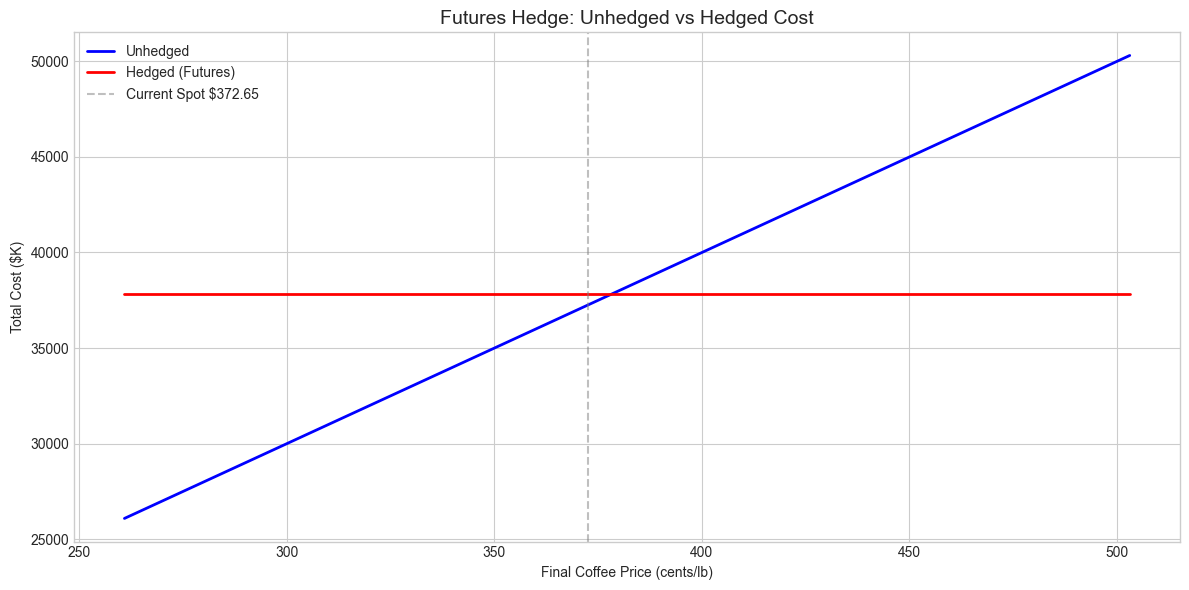

In [8]:
# simulate different price outcomes
price_outcomes = np.arange(spot * 0.7, spot * 1.4, spot * 0.05)

hedge_results = []
for final_price in price_outcomes:
    # unhedged
    unhedged_cost = final_price * position_size
    
    # hedged with futures
    physical_cost = final_price * position_size
    futures_pnl = (final_price - futures_3m) * position_size
    hedged_cost = physical_cost - futures_pnl
    
    hedge_results.append({
        'final_price': final_price,
        'unhedged': unhedged_cost,
        'hedged': hedged_cost,
        'savings': unhedged_cost - hedged_cost
    })

hedge_df = pd.DataFrame(hedge_results)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(hedge_df['final_price'], hedge_df['unhedged']/1000, 'b-', linewidth=2, label='Unhedged')
ax.plot(hedge_df['final_price'], hedge_df['hedged']/1000, 'r-', linewidth=2, label='Hedged (Futures)')
ax.axvline(spot, color='gray', linestyle='--', alpha=0.5, label=f'Current Spot ${spot:.2f}')

ax.set_xlabel('Final Coffee Price (cents/lb)')
ax.set_ylabel('Total Cost ($K)')
ax.set_title('Futures Hedge: Unhedged vs Hedged Cost', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/futures_hedge.png', dpi=150)
plt.show()

## 5. Options Hedging

In [9]:
# protective call strategy (for buyer needing to purchase)
strike = spot * 1.05  # 5% OTM call
call_premium = black_scholes(spot, strike, hedge_maturity, risk_free, volatility, q, 'call')

print("CALL OPTION HEDGE")
print("=" * 50)
print(f"Strike: ${strike:.2f} (5% above spot)")
print(f"Premium: ${call_premium:.2f}/lb")
print(f"Total Premium: ${call_premium * position_size:,.0f}")
print(f"\nMaximum Cost: ${(strike + call_premium) * position_size:,.0f}")
print(f"  (Strike + Premium)")

CALL OPTION HEDGE
Strike: $391.28 (5% above spot)
Premium: $20.85/lb
Total Premium: $2,084,513

Maximum Cost: $41,212,763
  (Strike + Premium)


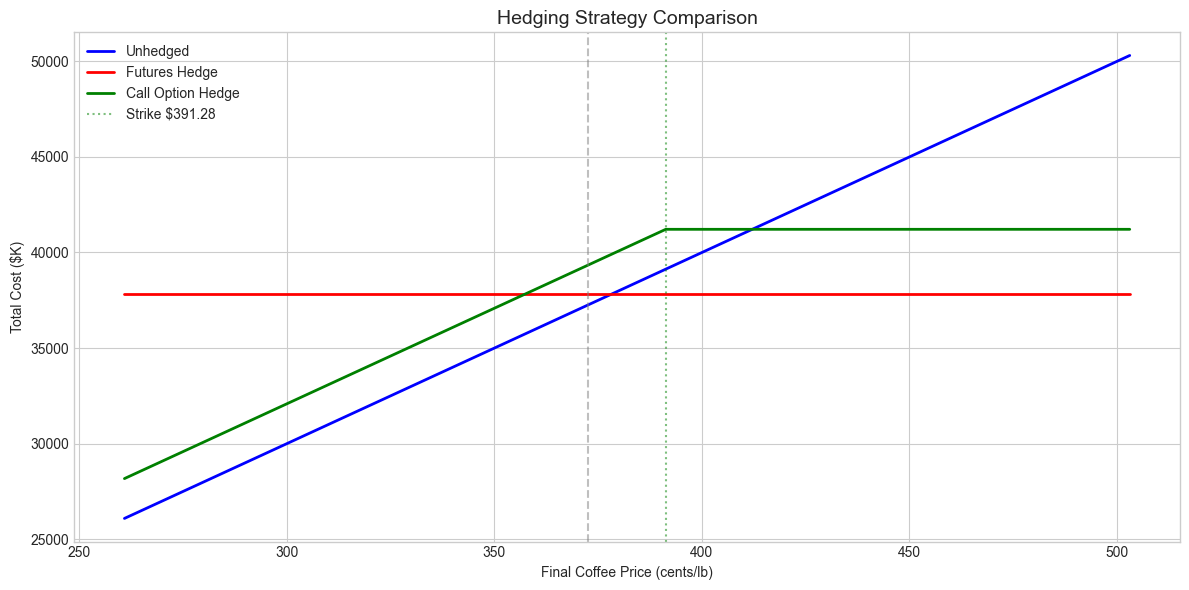

In [10]:
# compare strategies
strategies = []

for final_price in price_outcomes:
    # unhedged
    unhedged = final_price * position_size
    
    # futures hedge
    futures_hedge = futures_3m * position_size
    
    # call option hedge
    if final_price > strike:
        call_hedge = (strike + call_premium) * position_size
    else:
        call_hedge = (final_price + call_premium) * position_size
    
    strategies.append({
        'price': final_price,
        'unhedged': unhedged,
        'futures': futures_hedge,
        'call_option': call_hedge
    })

strat_df = pd.DataFrame(strategies)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(strat_df['price'], strat_df['unhedged']/1000, 'b-', linewidth=2, label='Unhedged')
ax.plot(strat_df['price'], strat_df['futures']/1000, 'r-', linewidth=2, label='Futures Hedge')
ax.plot(strat_df['price'], strat_df['call_option']/1000, 'g-', linewidth=2, label='Call Option Hedge')

ax.axvline(spot, color='gray', linestyle='--', alpha=0.5)
ax.axvline(strike, color='green', linestyle=':', alpha=0.5, label=f'Strike ${strike:.2f}')

ax.set_xlabel('Final Coffee Price (cents/lb)')
ax.set_ylabel('Total Cost ($K)')
ax.set_title('Hedging Strategy Comparison', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/hedge_comparison.png', dpi=150)
plt.show()

## 6. Collar Strategy

In [11]:
# collar for inventory holder (long coffee)
# buy put (protection) + sell call (finance put)

put_strike = spot * 0.90   # 10% OTM put
call_strike = spot * 1.10  # 10% OTM call

put_premium = black_scholes(spot, put_strike, hedge_maturity, risk_free, volatility, q, 'put')
call_premium_sold = black_scholes(spot, call_strike, hedge_maturity, risk_free, volatility, q, 'call')

net_premium = call_premium_sold - put_premium

print("COLLAR STRATEGY")
print("=" * 50)
print(f"Spot: ${spot:.2f}")
print(f"\nBuy Put @ ${put_strike:.2f}: Premium ${put_premium:.2f}")
print(f"Sell Call @ ${call_strike:.2f}: Premium ${call_premium_sold:.2f}")
print(f"\nNet Premium: ${net_premium:.2f}/lb ({'Credit' if net_premium > 0 else 'Debit'})")
print(f"\nFloor Price: ${put_strike:.2f}")
print(f"Ceiling Price: ${call_strike:.2f}")

COLLAR STRATEGY
Spot: $372.65

Buy Put @ $335.38: Premium $10.24
Sell Call @ $409.91: Premium $14.71

Net Premium: $4.47/lb (Credit)

Floor Price: $335.38
Ceiling Price: $409.91


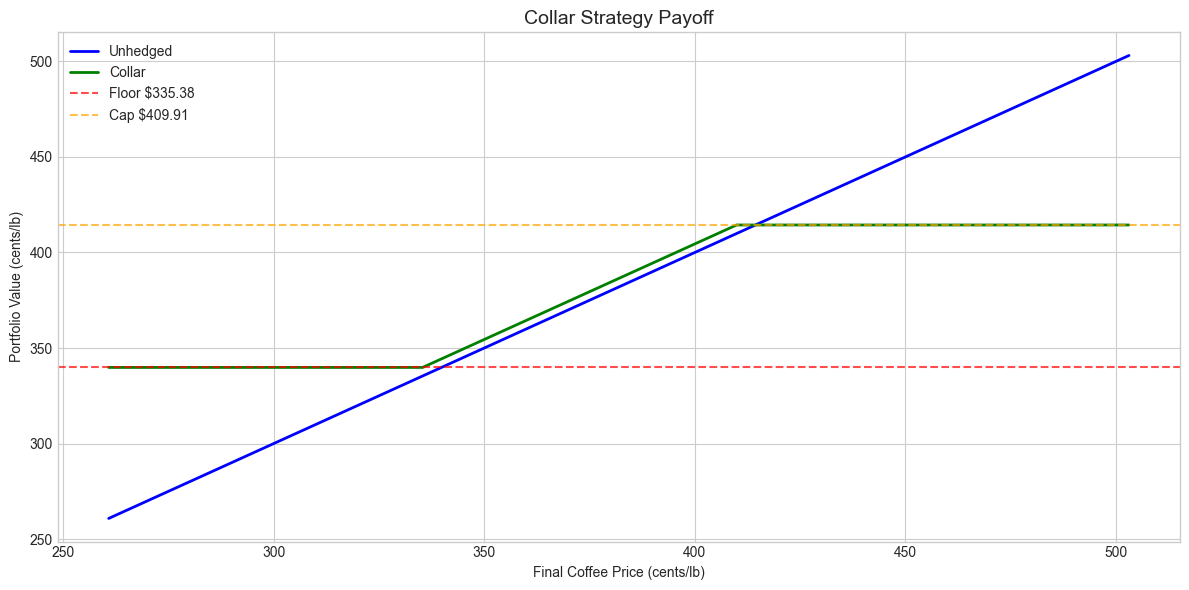

In [12]:
# collar payoff
collar_results = []

for final_price in price_outcomes:
    # long underlying
    underlying = final_price
    
    # put payoff
    put_payoff = max(put_strike - final_price, 0)
    
    # call payoff (sold, so negative)
    call_payoff = -max(final_price - call_strike, 0)
    
    # total
    collar_value = underlying + put_payoff + call_payoff + net_premium
    
    collar_results.append({
        'price': final_price,
        'underlying': underlying,
        'collar': collar_value
    })

collar_df = pd.DataFrame(collar_results)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(collar_df['price'], collar_df['underlying'], 'b-', linewidth=2, label='Unhedged')
ax.plot(collar_df['price'], collar_df['collar'], 'g-', linewidth=2, label='Collar')

ax.axhline(put_strike + net_premium, color='red', linestyle='--', alpha=0.7, label=f'Floor ${put_strike:.2f}')
ax.axhline(call_strike + net_premium, color='orange', linestyle='--', alpha=0.7, label=f'Cap ${call_strike:.2f}')

ax.set_xlabel('Final Coffee Price (cents/lb)')
ax.set_ylabel('Portfolio Value (cents/lb)')
ax.set_title('Collar Strategy Payoff', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/collar_payoff.png', dpi=150)
plt.show()

## 7. Optimal Hedge Ratio

In [13]:
# minimum variance hedge ratio
returns = df['returns'].dropna()

# for simplicity, assume futures returns = spot returns (high correlation)
# in practice, get actual futures data
spot_returns = returns.values
futures_returns = returns.values * 0.95 + np.random.normal(0, 0.005, len(returns))  # simulated

# hedge ratio
correlation = np.corrcoef(spot_returns, futures_returns)[0, 1]
spot_vol = spot_returns.std()
futures_vol = futures_returns.std()

hedge_ratio = correlation * (spot_vol / futures_vol)

print("OPTIMAL HEDGE RATIO")
print("=" * 40)
print(f"Correlation: {correlation:.4f}")
print(f"Spot Volatility: {spot_vol:.4f}")
print(f"Futures Volatility: {futures_vol:.4f}")
print(f"\nMinimum Variance Hedge Ratio: {hedge_ratio:.4f}")
print(f"\nFor {position_size:,} lbs exposure:")
print(f"  Hedge with {position_size * hedge_ratio:,.0f} lbs in futures")

OPTIMAL HEDGE RATIO
Correlation: 0.9741
Spot Volatility: 0.0230
Futures Volatility: 0.0224

Minimum Variance Hedge Ratio: 0.9987

For 100,000 lbs exposure:
  Hedge with 99,869 lbs in futures


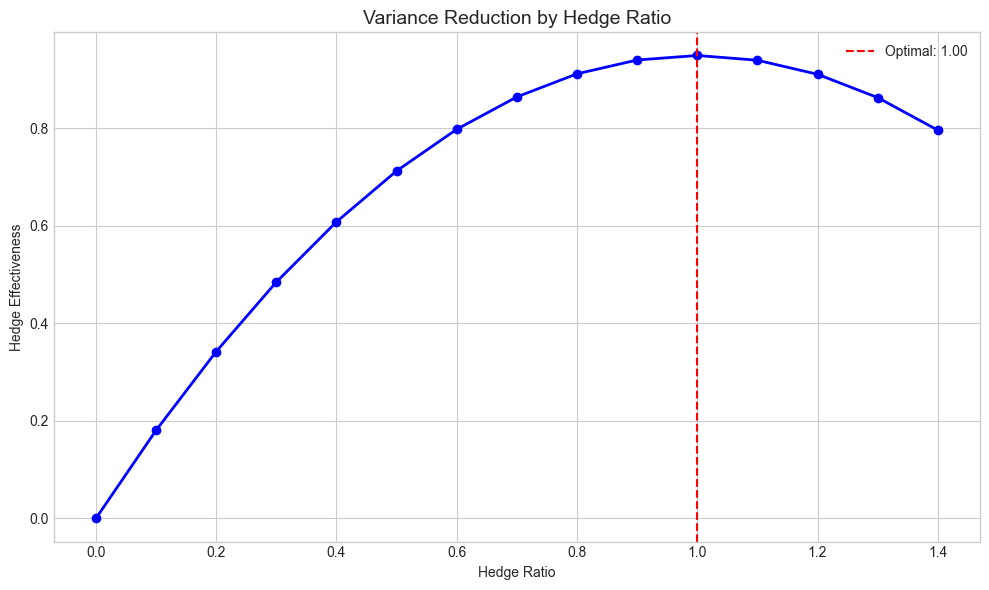

Maximum Hedge Effectiveness: 94.9% variance reduction


In [14]:
# hedge effectiveness at different ratios
ratios = np.arange(0, 1.5, 0.1)
effectiveness = []

unhedged_var = spot_returns.var()

for h in ratios:
    hedged_returns = spot_returns - h * futures_returns
    hedged_var = hedged_returns.var()
    eff = 1 - hedged_var / unhedged_var
    effectiveness.append(eff)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(ratios, effectiveness, 'b-o', linewidth=2, markersize=6)
ax.axvline(hedge_ratio, color='red', linestyle='--', label=f'Optimal: {hedge_ratio:.2f}')

ax.set_xlabel('Hedge Ratio')
ax.set_ylabel('Hedge Effectiveness')
ax.set_title('Variance Reduction by Hedge Ratio', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/hedge_effectiveness.png', dpi=150)
plt.show()

max_eff = max(effectiveness)
print(f"Maximum Hedge Effectiveness: {max_eff:.1%} variance reduction")

## 8. Strategy Comparison

In [15]:
# comprehensive comparison
print("\nHEDGING STRATEGY COMPARISON")
print("=" * 70)

print(f"\n{'Strategy':<20} {'Cost':>12} {'Floor':>12} {'Cap':>12} {'Best When':>15}")
print("-" * 70)

# unhedged
print(f"{'Unhedged':<20} {'$0':>12} {'None':>12} {'None':>12} {'Prices fall':>15}")

# futures
basis_cost = (futures_3m - spot) * position_size
print(f"{'Futures Hedge':<20} ${basis_cost:>11,.0f} ${futures_3m:>11.2f} ${futures_3m:>11.2f} {'Lock price':>15}")

# call option
option_cost = call_premium * position_size
print(f"{'Call Option':<20} ${option_cost:>11,.0f} {'Market':>12} ${strike:>11.2f} {'Expect rise':>15}")

# collar
collar_cost = net_premium * position_size
print(f"{'Collar':<20} ${abs(collar_cost):>11,.0f} ${put_strike:>11.2f} ${call_strike:>11.2f} {'Low cost hedge':>15}")


HEDGING STRATEGY COMPARISON

Strategy                     Cost        Floor          Cap       Best When
----------------------------------------------------------------------
Unhedged                       $0         None         None     Prices fall
Futures Hedge        $    563,188 $     378.28 $     378.28      Lock price
Call Option          $  2,084,513       Market $     391.28     Expect rise
Collar               $    447,452 $     335.38 $     409.91  Low cost hedge


## 9. Summary Report

In [16]:
print("\n" + "=" * 70)
print("HEDGING ANALYSIS SUMMARY REPORT")
print("=" * 70)

summary = f"""
MARKET CONDITIONS:
------------------
Spot Price: ${spot:.2f} cents/lb
3-Month Futures: ${futures_3m:.2f} cents/lb
Implied Volatility: {volatility:.1%}
Market Structure: {'Contango' if futures_3m > spot else 'Backwardation'}

HEDGING REQUIREMENT:
--------------------
Physical Exposure: {position_size:,} lbs
Time Horizon: 3 months
Current Exposure Value: ${spot * position_size:,.0f}

STRATEGY ANALYSIS:
------------------

1. FUTURES HEDGE
   Locked Price: ${futures_3m:.2f}/lb
   Total Cost: ${futures_3m * position_size:,.0f}
   Pro: Perfect price lock
   Con: No upside if prices fall

2. CALL OPTION HEDGE
   Strike: ${strike:.2f}, Premium: ${call_premium:.2f}
   Max Cost: ${(strike + call_premium) * position_size:,.0f}
   Pro: Benefit if prices fall
   Con: Premium cost

3. COLLAR
   Floor: ${put_strike:.2f}, Cap: ${call_strike:.2f}
   Net Cost: ${abs(net_premium * position_size):,.0f} {'credit' if net_premium > 0 else 'debit'}
   Pro: Low/zero cost protection
   Con: Capped upside

OPTIMAL HEDGE:
--------------
Minimum Variance Ratio: {hedge_ratio:.2f}
Hedge Effectiveness: {max_eff:.1%} variance reduction

RECOMMENDATION:
---------------
Given current market conditions:
- Use FUTURES if you need price certainty
- Use OPTIONS if you expect prices to fall but want upside protection
- Use COLLAR for cost-effective hedging with defined range
"""

print(summary)


HEDGING ANALYSIS SUMMARY REPORT

MARKET CONDITIONS:
------------------
Spot Price: $372.65 cents/lb
3-Month Futures: $378.28 cents/lb
Implied Volatility: 36.5%
Market Structure: Contango

HEDGING REQUIREMENT:
--------------------
Physical Exposure: 100,000 lbs
Time Horizon: 3 months
Current Exposure Value: $37,264,999

STRATEGY ANALYSIS:
------------------

1. FUTURES HEDGE
   Locked Price: $378.28/lb
   Total Cost: $37,828,188
   Pro: Perfect price lock
   Con: No upside if prices fall

2. CALL OPTION HEDGE
   Strike: $391.28, Premium: $20.85
   Max Cost: $41,212,763
   Pro: Benefit if prices fall
   Con: Premium cost

3. COLLAR
   Floor: $335.38, Cap: $409.91
   Net Cost: $447,452 credit
   Pro: Low/zero cost protection
   Con: Capped upside

OPTIMAL HEDGE:
--------------
Minimum Variance Ratio: 1.00
Hedge Effectiveness: 94.9% variance reduction

RECOMMENDATION:
---------------
Given current market conditions:
- Use FUTURES if you need price certainty
- Use OPTIONS if you expect pri